In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import docx
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

sns.set_style("whitegrid")
save_folder = 'Lennart Figures/LOO classifier comparison6/'

In [11]:
LR_names = ['LogisticRegression'] 
kernels = ['rbf', 'linear'] # These are the best performing ones
SVM_names = ['SVM kernel=%s' %kernel for kernel in kernels] 
activation = ['identity', 'logistic', 'tanh', 'relu']
MLP_names = ['Neural net activation=%s' %act for act in activation]  
RandF_names = ['RandF n=%s' %str(n) for n in [50,100,500]]
NB_names = ['Gaussian NB', 'Gaussian NB, calibrated']

classifiers_names = LR_names + NB_names + SVM_names + MLP_names + RandF_names  

classifiers_names_article = ['Logistic Regression', 'Gaussian NB', 'SVM (rbf)',
       'SVM (linear)', 'Neural net (identity)',
       'Neural net (logistic)', 'Neural net (tanh)',
       'Neural net (relu)', 'RandF n=100',
       'RandF n=500']

# Probability Scaling - LOGO Experiments

In [17]:
fig2 = pd.read_pickle(save_folder+'roc_curves.pkl')
fig2ov = pd.read_pickle(save_folder+'accumulate.pkl')

for z in range(6):
    pract_Ys = []
    for clf_name in classifiers_names:
        fig2select = fig2[(fig2['method']==clf_name) & (fig2['novelty_method']=='prob_all') & (fig2['short']==z)]

        # Get accumulated threshold
        fig2ovselect = fig2ov[(fig2ov['method']==clf_name) & (fig2ov['novelty_method']=='prob_all') & (fig2ov['short']==z)]
        acc_thresh = accumulated_ROC(fig2ovselect)

        pract_Y = []
        for i,label in enumerate(fig2select['species'].values):
            # Load values
            fpr = fig2select[fig2select['species']==label]['fpr'].values[0]
            tpr = fig2select[fig2select['species']==label]['tpr'].values[0]
            thresholds = fig2select[fig2select['species']==label]['thresholds'].values[0]
            roc_auc = fig2select['auc'].values[i]
            # Calculate youden
            youden_index = tpr - fpr 
            threshold = thresholds[np.argmax(youden_index)]
            fpr_thresh = fpr[np.argmax(youden_index)]
            tpr_thresh = tpr[np.argmax(youden_index)]

            #  Find threshold near accumulated_threshold
            idx = find_nearest(thresholds, acc_thresh)

            # Save data to compare optimal vs real threshold
            pract_Y.append([tpr_thresh-fpr_thresh, tpr[idx]-fpr[idx]])
        pract_Ys.append(np.mean(pract_Y, axis=0)) 
    if(z==0):
        pract_Ys_df = pd.DataFrame(pract_Ys, index=classifiers_names) 
    else:
        pract_Ys_df = pd.concat([pract_Ys_df, pd.DataFrame(pract_Ys, index=classifiers_names)], axis=1)

0.9035437147667283 0.9993486766120872
0.5858719281729892 0.9999999999999432
0.601684717115174 0.9719696395717925
0.930133045234901 0.9862646971028319
0.9367110135269534 0.9856129828342451
0.8759751749134028 0.9999890077423624
0.9702450839573197 0.998109375650428
0.9606751740208244 0.9990352446532056
0.942234427666239 0.9995025552252398
0.9866678863578274 0.86
0.9881845352502132 0.84
0.9890205522614641 0.842
0.8893449222942208 0.9992732610464895
0.6166603039278228 0.9999999999999787
0.6017991034688213 0.970100659849467
0.9718901926907589 0.97736931490992
0.9288286505287464 0.9910625612490005
0.8463798542457427 0.999998226848087
0.9742232501225716 0.9987042376733037
0.9534400435112937 0.9992636200063795
0.9286507232188491 0.9997017901413101
0.9881671981165894 0.86
0.9881680375061181 0.88
0.9891378689987533 0.888
0.8044201637587471 0.8723005308409896
0.601684717115174 0.9719696395717925
0.61388319198263 0.9719245416126052
0.5961266577963971 0.9372285740075131
0.7862040047989146 0.95154479

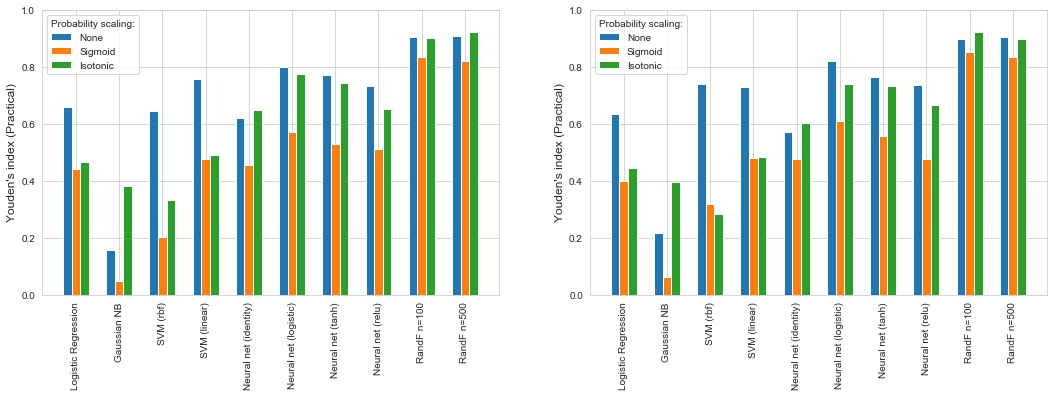

In [55]:
toplot = [0,1,3,4,5,6,7,8,10,11]
pos = [-.2,0,.2,-.2,0,.2]
cols = ['C0','C1','C2','C0','C1','C2']
lab = ['None', 'Sigmoid', 'Isotonic','None', 'Sigmoid', 'Isotonic']

f, axs = plt.subplots(1, 2, figsize=(18,6.96/1.33))
for k,l in enumerate([0,2,4,1,3,5]):
    color = cols[k]
    for i,j in enumerate(toplot):
        axs[int(not(k<3))].bar(i+pos[k], pract_Ys_df[1].iloc[:,l].values[j] ,color=color, width=0.2, label=lab[k] if i==0 else '')

for ax in axs:
    ax.set_xticks(np.arange(len(toplot)))
    ax.set_xticklabels(classifiers_names_article, rotation='vertical')    
    leg = ax.legend(title='Probability scaling:')
    leg._legend_box.align = "left"
    ax.set_ylim(0,1.0)
    ax.set_ylabel("Youden's index (Practical)", fontsize=12) 
plt.show()

# Probability Scaling - uMelts

In [96]:
# save_folder = 'Lennart Figures/LOO classifier comparison6/'
save_folder = 'Lennart Figures/LOO classifier comparison6/dropEc/'

In [97]:
fig2ov = pd.read_pickle(save_folder+'accumulate.pkl')

compare_all = []
for i in range(6):
    df_roc_curves = pd.read_pickle(save_folder+'uMelt_roc_curves'+str(i)+'.pkl')
    df_fig_save = pd.read_pickle(save_folder+'uMelt_fig_save'+str(i)+'.pkl')

    # Get all accumulated thresholds
    acc_thresholds = []
    for method in classifiers_names:
        fig2ovselect = fig2ov[(fig2ov['method']==method) & (fig2ov['novelty_method']=='prob_all') & (fig2ov['short']==i)]
        acc_thresholds.append(accumulated_ROC(fig2ovselect))

    compare_sens_spec = []
    for method, acc_thresh in zip(classifiers_names, acc_thresholds):
        select_roc = df_roc_curves[(df_roc_curves['novelty_method']=='prob_all') & (df_roc_curves['method']==method)]
        plot_boxplot_data = plot_boxplot_simple_data(select_roc['fpr'].values[0], select_roc['tpr'].values[0], select_roc['thresholds'].values[0], acc_thresh)
        compare_sens_spec.append(plot_boxplot_data)

    compare_all.append(compare_sens_spec)
compare = [pd.DataFrame(comp_all, index=classifiers_names, columns=['Optimal Youden', 'Practical Youden']) for comp_all in compare_all]

0.9515296099387229 0.9980503716251309
0.6173186087453377 1.0
0.4848694139232041 0.9872041764690864
0.9381428259854419 0.9858537938915783
0.9469403763062456 0.9825233379554111
0.9312958029675628 0.9997650681286714
0.9822005395355792 0.9952939878914161
0.9776484076824233 0.9974074102747101
0.9644082059666212 0.9984460857994736
0.9922874249813591 0.86
0.992748334545433 0.88
0.9941656239540464 0.854
0.9426251294703928 0.9983742867359456
0.655312030916752 0.9999999999999858
0.49039674777647746 0.9793572406951914
0.986542604706435 0.9814584580656022
0.9423541635896652 0.9848882121424524
0.8965349026039247 0.999992289410626
0.9784464268000534 0.9982661825979733
0.9774814188498042 0.9989504249521957
0.9663542902626282 0.9993312454431225
0.9925371416985673 0.9
0.9928908642345116 0.89
0.9934382418647607 0.904
0.8861895500600596 0.9292910312523377
0.4848694139232041 0.9872041764690864
0.5086296449381914 0.9873579483880004
0.6110091525737001 0.9369723076985921
0.7538371663447199 0.9363387664882795

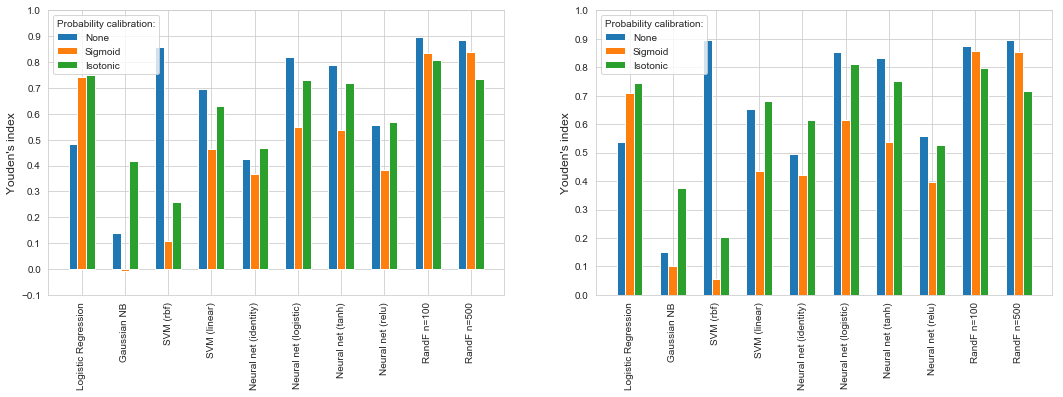

In [99]:
toplot = [0,1,3,4,5,6,7,8,10,11]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6.96/1.33))
for i,j in enumerate(toplot):
    ax1.bar(i-.2,compare[0].iloc[j,1],color='C0', width=0.2, label='None' if i==0 else '')
    ax1.bar(i,compare[2].iloc[j,1],color='C1', width=0.2, label='Sigmoid' if i==0 else '')
    ax1.bar(i+.2,compare[4].iloc[j,1],color='C2', width=0.2, label='Isotonic' if i==0 else '')
ax1.set_ylabel("Youden's index", fontsize=12) 
ax1.set_xticks(np.arange(len(toplot)))
ax1.set_xticklabels(classifiers_names_article, rotation='vertical')
leg = ax1.legend(title='Probability calibration:', loc='upper left')
leg._legend_box.align = "left"
ax1.set_ylim(-0.2,1.0)
ax1.set_yticks([0.1*i for i in range(-2,11)])

for i,j in enumerate(toplot):
    ax2.bar(i-.2,compare[1].iloc[j,1],color='C0', width=0.2, label='None' if i==0 else '')
    ax2.bar(i,compare[3].iloc[j,1],color='C1', width=0.2, label='Sigmoid' if i==0 else '')
    ax2.bar(i+.2,compare[5].iloc[j,1],color='C2', width=0.2, label='Isotonic' if i==0 else '')
ax2.set_ylabel("Youden's index", fontsize=12) 
ax2.set_xticks(np.arange(len(toplot)))
ax2.set_xticklabels(classifiers_names_article, rotation='vertical')
leg = ax2.legend(title='Probability calibration:', loc='upper left')
leg._legend_box.align = "left"
ax2.set_ylim(-0.2,1.0)
ax2.set_yticks([0.1*i for i in range(-2,11)])

if(save_folder == 'Lennart Figures/LOO classifier comparison6/dropEc/'):
    ax1.set_ylim(-0.1,1.0)
    ax1.set_yticks([0.1*i for i in range(-1,11)])
    ax2.set_ylim(0,1.0)
    ax2.set_yticks([0.1*i for i in range(11)])

plt.savefig('//172.16.236.148/meltanalysis2/Lennart/Publications/2. Probabilistic novelty detection/Supplementary Figures/FigureS5b.svg', bbox_inches='tight')
plt.show()

# Helper Functions

In [59]:
def accumulated_ROC(fig2ovselect, plot=False):
    y_true = np.concatenate(fig2ovselect['Known'].values)
    y_scores = np.concatenate(fig2ovselect['Probability'].values)
    y_weights = np.concatenate(fig2ovselect['weights'].values)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)  
    roc_auc_all = auc(fpr, tpr)
    youden_index = tpr - fpr 
    acc_thresh = thresholds[np.argmax(youden_index)]
    fpr_thresh = fpr[np.argmax(youden_index)]
    tpr_thresh = tpr[np.argmax(youden_index)]
    print(roc_auc_all, acc_thresh)

    if(plot):
        plt.plot(fpr, tpr, label='Accumulated LOO experiments (area = %0.2f)' %(roc_auc_all))
        plt.plot(fpr_thresh, tpr_thresh, '+', mew=2, ms=20, label='Optimal threshold')

    if(plot):
        plt.plot([0, 1], [0, 1], color='black', linestyle='--')
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.legend(loc='lower right')
        plt.show()
    
    return acc_thresh
    
# Used to find nearest threshold
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
#     print('nearest difference:', min(np.abs(array - value))) # to make sure differences aren't too big
#     print(array[idx])
    return idx

def plot_boxplot_simple_data(fpr, tpr, thresholds, acc_thresh, option=0):
     # Calculate youden
    youden_index = tpr - fpr 
    fpr_thresh = fpr[np.argmax(youden_index)]
    tpr_thresh = tpr[np.argmax(youden_index)]
    
    #  Find threshold near accumulated_threshold
    idx = find_nearest(thresholds, acc_thresh)
    
    if (option==0):
        return [tpr_thresh-fpr_thresh, tpr[idx]-fpr[idx]]
    else:
        return [1-fpr_thresh, tpr_thresh, tpr_thresh-fpr_thresh, 1-fpr[idx], tpr[idx], tpr[idx]-fpr[idx]]